# I. Entendimento do negócio

## A. Contexto 

A EletroPlaza Store é um conglomerado de lojas especializado em eletrônicos, eletrodomésticos e acessórios, com presença global. Apesar da forte presença online, **as vendas da empresa são predominantemente físicas.**

Após investimentos significativos nos setores de vendas, marketing e desenvolvimento de produtos, a empresa experimentou um grande aumento no faturamento no último ano. No entanto, **novos desafios surgiram, especialmente em compreender como as vendas se comportarão nas próximas semanas, com a aproximação da Black Friday e o Natal.**

## B. Desafio

O ano está chegando ao fim, **a Black Friday e o Natal estão se aproximando e as vendas tendem a subir exponencialmente nessa época e os dados de comparação do ano passado já não servem mais como termômetro para a empresa. **

A urgência em entender os possíveis resultados é grande, pois **a equipe de negócio tem uma meta de faturamento e está preocupada se conseguirá alcançá-la.**

## C. Objetivo

O objetivo é **construir uma solução que preveja as vendas semanais das lojas e de seus variados setores para as 5 semanas finais do ano.**

A análise deve abranger diversos setores e considerar fatores externos, como temperatura, preço do combustível e taxa de desemprego.


## D. Expectativa

Os gestores da EletroPlaza Store esperam poder:
- Definir planos;
- Organizar estoques;
- Calcular receitas;
- Decidir se farão novos investimentos ou não;
- Decidir onde devem alocar estes novos investimentos, mediante campanhas mais eficientes de marketing e vendas.


# II. Entendimento dos dados

## 0. IMPORTS

### 0.1. Importing libraries

In [1]:
import pandas             as pd
import seaborn            as sns
import numpy              as np
import matplotlib.pyplot  as plt

import math
import random
#import ydata_profiling

from sklearn              import preprocessing as pp
from sklearn              import ensemble as en
from sklearn              import model_selection as ms
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.svm          import SVR
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.ensemble     import GradientBoostingRegressor
from sklearn.metrics      import mean_squared_error
from datetime             import datetime, timedelta
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor

### 0.2. Loading data

In [2]:
stores         = pd.read_csv('datasets/stores.csv', low_memory=False)
train          = pd.read_csv('datasets/train.csv', low_memory=False)
train_features = pd.read_csv('datasets/train_features.csv', low_memory=False)

test           = pd.read_csv('datasets/test.csv', low_memory=False)
test_features  = pd.read_csv('datasets/test_features.csv', low_memory=False)

### 0.3. Helper functions

In [3]:
# Função que retorna uma tabela de únicos e suas respectivas quantidades
def tab_unique(df):
    tab_unicos = pd.DataFrame(df.nunique())
    tab_unicos.columns= ['count']
    tab_unicos['content'] = df.apply(lambda x: x.unique())
    return tab_unicos

In [4]:
def cross_validation(x_training,kfold,model_name,model,verbose=False):
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'K = {k}')
        validation_start_date = x_training['data'].max() - timedelta(days=k*6*7)
        validation_end_date = x_training['data'].max() - timedelta(days=(k-1)*6*7)

        # Filtrar o dataset
        training   = x_training[x_training['data'] < validation_start_date] #Resto dos dados
        validation = x_training[(x_training['data'] >= validation_start_date) & (x_training['data'] <= 
                                                       validation_end_date)] # Começo até o início do treino

        training_start = training['data'].max()
        training_end = training['data'].min()

        validation_start = validation['data'].max()
        validation_end = validation['data'].min()

        # Training and validation dataset
        # training
        xtraining = training.drop(['data','vendas_semanais','id'],axis=1)
        ytraining = training['vendas_semanais']

        # Validation
        xvalidation = validation.drop(['data','vendas_semanais','id'],axis=1)
        yvalidation = validation['vendas_semanais']

        # Como fizemos para selecionar as variáveis para o Boruta
        # Estamos selecionando os datasets de treino e validação

        # Model
        m = model.fit(xtraining,ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance - Y_test é a coluna de sales que devemos encontrar e yhat é o que nosso método prediz
        rmse = np.sqrt(mean_squared_error(np.expm1(yvalidation), np.expm1(yhat)))

        # Guardando a performance de cada iteração
        rmse_list.append(rmse)

    return pd.DataFrame({'Model Name':model_name,
         'RSME CV':np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + 
                         np.round(np.std(rmse_list),2).astype(str)},index=[0])

### 0.4. Dicionário de dados

**Arquivos**
- stores.csv - características das lojas
- train.csv - dados de treino
- features.csv - atributos complementares
- test.csv - dados de teste
- sample_submission.csv - exemplo de submissão

**train.csv**

Feature | Description
-- | --
id | identificador único do registro
loja | identificador único da loja
setor | setor específico da loja
data | semana (mês-dia) em que ocorreram as vendas
vendas_semanais | valor total das vendas semanais, em US$
feriado | se há feriado ou não na semana

**features.csv**

Feature | Description
-- | --
loja | identificador único da loja
data | semana (mês-dia) em que ocorreram as vendas
temperatura | temperatura média da loja na semana, em °C
combustivel | preço médio do combustível na semana, em US$
desconto_1 | desconto promocional especial do tipo 1
desconto_2 | desconto promocional especial do tipo 2
desconto_3 | desconto promocional especial do tipo 3
desconto_4 | desconto promocional especial do tipo 4
desconto_5 | desconto promocional especial do tipo 5
desemprego | taxa média de desemprego do país na semana
feriado | se há feriado ou não na semana
distancia_competidores | distância média entre as lojas competidoras, em polegadas
clientes | quantidades de clientes presentes na loja, em média diária, durante aquela semana

**stores.csv**

Feature | Description
-- | --
loja | identificador único da loja;
tipo | eletrônico, eletrodomésticos ou acessórios;
tamanho | tamanho da loja, unidade não definida.

## 1. DATA DESCRIPTION

### 1.1. Unir tabelas

In [5]:
df  = pd.merge(train, stores, on='loja', how='inner')
df1 = pd.merge(df, train_features, on=['loja', 'data', 'feriado'], how='inner')

### 1.2. Data Dimensions

In [6]:
print('Quantidade de linhas: {:,}'.format(df1.shape[0]))
print('Quantidade de colunas: {:,}'.format(df1.shape[1]))

Quantidade de linhas: 135,385
Quantidade de colunas: 18


### 1.3. Check NA's

In [7]:
df1.isna().sum()

id                             0
loja                           0
setor                          0
data                           0
vendas_semanais            12862
feriado                        0
tipo                           0
tamanho                    33327
temperatura                47945
combustivel                52989
desconto_1                129459
desconto_2                129510
desconto_3                129746
desconto_4                130184
desconto_5                129459
desemprego                     0
distancia_competidores    129459
clientes                       0
dtype: int64

In [8]:
stores.isna().sum()

loja        0
tipo        0
tamanho    11
dtype: int64

### 1.4. Data Types

In [9]:
df1.dtypes

id                          int64
loja                        int64
setor                       int64
data                       object
vendas_semanais           float64
feriado                    object
tipo                       object
tamanho                   float64
temperatura               float64
combustivel               float64
desconto_1                float64
desconto_2                float64
desconto_3                float64
desconto_4                float64
desconto_5                float64
desemprego                float64
distancia_competidores    float64
clientes                    int64
dtype: object

### 1.5. Check duplicated

In [10]:
# Verificar a existência de registros duplicados
df1.duplicated().sum()

0

## 2. TRATAMENTO DE DADOS E FEATURE ENGINEERING

In [11]:
df2 = df1.copy()

### 2.1. Criação das Hipóteses

### 2.2. Transformar e converter

#### 2.2.1. Preencher NA´s e excluir colunas

##### 2.2.1.1. Excluir os registros com vendas semanais nula ou menor que 1

In [12]:
reg_faltantes = df2.loc[(df2['vendas_semanais'].isna()) | (df2['vendas_semanais'] < 1), :].index
df2.drop(reg_faltantes, axis=0, inplace=True)

df2.reset_index(inplace=True,drop=True)
df2.tail()

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
121991,275307,33,90,11-18,23462.71,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121992,275374,33,96,11-18,10445.16,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121993,275387,33,95,11-18,25464.21,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121994,275397,33,98,11-18,7730.53,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156
121995,275405,33,97,11-18,4665.16,nao,eletrodomestico,39690.0,NaN,3.669,86.59,6.0,NaN,NaN,3220.86,0.0801,1952.0,156


##### 2.2.1.2. Preencher os descontos com valores nulos com 0

In [13]:
df2['desconto_1'] = df2['desconto_1'].fillna(0)
df2['desconto_2'] = df2['desconto_2'].fillna(0)
df2['desconto_3'] = df2['desconto_3'].fillna(0)
df2['desconto_4'] = df2['desconto_4'].fillna(0)
df2['desconto_5'] = df2['desconto_5'].fillna(0)

##### 2.2.1.3.  Preencher o tamanho das lojas faltantes com a mediana

In [14]:
%%time
mediana = df2['tamanho'].median()
tam_faltantes = df2.loc[df2['tamanho'].isna(), :].index
df2['tamanho'] = df2['tamanho'].apply(lambda x: mediana if math.isnan(x) else x)

CPU times: total: 46.9 ms
Wall time: 113 ms


In [15]:
df2.iloc[tam_faltantes, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
5623,140681,3,25,01-07,2658.57,nao,eletronico,128107.0,11.861111,NaN,0.00,0.00,0.0,0.00,0.0,0.07551,NaN,901
5624,141029,3,20,01-07,1358.81,nao,eletronico,128107.0,11.861111,NaN,0.00,0.00,0.0,0.00,0.0,0.07551,NaN,901
5625,141077,3,34,01-07,3280.50,nao,eletronico,128107.0,11.861111,NaN,0.00,0.00,0.0,0.00,0.0,0.07551,NaN,901
5626,141106,3,23,01-07,6530.88,nao,eletronico,128107.0,11.861111,NaN,0.00,0.00,0.0,0.00,0.0,0.07551,NaN,901
5627,141169,3,19,01-07,3113.76,nao,eletronico,128107.0,11.861111,NaN,0.00,0.00,0.0,0.00,0.0,0.07551,NaN,901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120106,274985,11,71,11-18,9419.43,nao,eletrodomestico,128107.0,NaN,NaN,10941.05,222.94,263.1,404.05,8885.3,0.07197,17997.0,953
120107,274997,11,67,11-18,9790.06,nao,eletrodomestico,128107.0,NaN,NaN,10941.05,222.94,263.1,404.05,8885.3,0.07197,17997.0,953
120108,275011,11,79,11-18,26994.74,nao,eletrodomestico,128107.0,NaN,NaN,10941.05,222.94,263.1,404.05,8885.3,0.07197,17997.0,953
120109,275018,11,74,11-18,18686.63,nao,eletrodomestico,128107.0,NaN,NaN,10941.05,222.94,263.1,404.05,8885.3,0.07197,17997.0,953


##### 2.2.1.4. Preencher a temperatura faltantes usando a média

In [16]:
%%time
media = df2['temperatura'].mean()
temp_faltantes = df2.loc[df2['temperatura'].isna(), :].index
df2['temperatura'] = df2['temperatura'].apply(lambda x: media if math.isnan(x) else x)

CPU times: total: 31.2 ms
Wall time: 116 ms


In [17]:
df2.iloc[temp_faltantes, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
129,146595,17,6,01-21,4548.82,nao,eletronico,93188.0,15.710478,2.934,0.00,0.0,0.0,0.0,0.00,0.06866,NaN,422
130,146907,17,1,01-21,16137.30,nao,eletronico,93188.0,15.710478,2.934,0.00,0.0,0.0,0.0,0.00,0.06866,NaN,422
131,146975,17,2,01-21,39712.80,nao,eletronico,93188.0,15.710478,2.934,0.00,0.0,0.0,0.0,0.00,0.06866,NaN,422
132,146986,17,3,01-21,16762.49,nao,eletronico,93188.0,15.710478,2.934,0.00,0.0,0.0,0.0,0.00,0.06866,NaN,422
133,147010,17,4,01-21,22773.89,nao,eletronico,93188.0,15.710478,2.934,0.00,0.0,0.0,0.0,0.00,0.06866,NaN,422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121991,275307,33,90,11-18,23462.71,nao,eletrodomestico,39690.0,15.710478,3.669,86.59,6.0,0.0,0.0,3220.86,0.08010,1952.0,156
121992,275374,33,96,11-18,10445.16,nao,eletrodomestico,39690.0,15.710478,3.669,86.59,6.0,0.0,0.0,3220.86,0.08010,1952.0,156
121993,275387,33,95,11-18,25464.21,nao,eletrodomestico,39690.0,15.710478,3.669,86.59,6.0,0.0,0.0,3220.86,0.08010,1952.0,156
121994,275397,33,98,11-18,7730.53,nao,eletrodomestico,39690.0,15.710478,3.669,86.59,6.0,0.0,0.0,3220.86,0.08010,1952.0,156


##### 2.2.1.5. Preencher os registros com combustível faltantes usando a média

In [18]:
%%time
media = df2['combustivel'].mean()
comb_faltantes = df2.loc[df2['combustivel'].isna(), :].index
df2['combustivel'] = df2['combustivel'].apply(lambda x: media if math.isnan(x) else x)

CPU times: total: 62.5 ms
Wall time: 112 ms


In [19]:
df2.iloc[comb_faltantes, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
377,158299,17,24,02-18,3652.300000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
378,158421,17,20,02-18,3273.070000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
379,158480,17,58,02-18,1200.000000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
380,158538,17,18,02-18,10202.870000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
381,158602,17,19,02-18,4271.550000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,NaN,956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121620,249134,33,5,09-16,110.000000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,NaN,685
121621,249156,33,9,09-16,41.780000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,NaN,685
121622,249248,33,81,09-16,887907.904893,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,NaN,685
121623,249292,33,90,09-16,25796.820000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,NaN,685


##### 2.2.1.6. Preencher os registros com distancia faltantes usando um número grande

In [20]:
%%time
comp_faltantes = df2.loc[df2['distancia_competidores'].isna(), :].index
df2['distancia_competidores'] = df2['distancia_competidores'].apply(lambda x: 300000 if math.isnan(x) else x)

CPU times: total: 109 ms
Wall time: 163 ms


In [21]:
df2.iloc[comb_faltantes, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,distancia_competidores,clientes
377,158299,17,24,02-18,3652.300000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
378,158421,17,20,02-18,3273.070000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
379,158480,17,58,02-18,1200.000000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
380,158538,17,18,02-18,10202.870000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
381,158602,17,19,02-18,4271.550000,nao,eletronico,93188.0,-2.855556,3.59723,0.0,0.0,0.0,0.0,0.0,0.06866,300000.0,956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121620,249134,33,5,09-16,110.000000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,300000.0,685
121621,249156,33,9,09-16,41.780000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,300000.0,685
121622,249248,33,81,09-16,887907.904893,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,300000.0,685
121623,249292,33,90,09-16,25796.820000,nao,eletrodomestico,39690.0,29.883333,3.59723,0.0,0.0,0.0,0.0,0.0,0.08442,300000.0,685


#### 2.2.2. Transformação de tipos

In [22]:
df2.dtypes

id                          int64
loja                        int64
setor                       int64
data                       object
vendas_semanais           float64
feriado                    object
tipo                       object
tamanho                   float64
temperatura               float64
combustivel               float64
desconto_1                float64
desconto_2                float64
desconto_3                float64
desconto_4                float64
desconto_5                float64
desemprego                float64
distancia_competidores    float64
clientes                    int64
dtype: object

##### 2.2.2.1 Transformar data nas colunas dia e mes

In [23]:
# Transformar o campo data em datetime
df2['data']          = pd.to_datetime(df2['data'] + '-2023', format='%m-%d-%Y')

# Criar novas colunas para análise detalhada
df2["week_of_year"]  = df2["data"].dt.strftime("%U")
df2["week_of_month"] = df2["data"].dt.day.apply(lambda x: (x - 1) // 7 + 1)
df2['month']         = df2['data'].dt.month
df2['day']           = df2['data'].dt.day

##### 2.2.2.2. Transformar feriado em 0 e 1

In [24]:
df2['feriado'] = df2['feriado'].apply(lambda x: 1 if x == 'sim' else 0)

In [25]:
df2['feriado'].unique()

array([0, 1], dtype=int64)

### 2.3. Criar

#### 2.3.1. Classificar as lojas pelo tamanho

In [26]:
q1 = df2['tamanho'].quantile(0.25)
q2 = df2['tamanho'].quantile(0.5)
q3 = df2['tamanho'].quantile(0.75)

df2['tipo_de_loja'] = df2['tamanho'].apply(lambda x: 'A' if x < q1 else
                                                     'B' if x < q3 else 'C')

In [27]:
df2.loc[:, ['tipo_de_loja', 'vendas_semanais']].groupby('tipo_de_loja').median()

,vendas_semanais
tipo_de_loja,
A,4757.605
B,8734.610
C,11520.665


#### 2.3.2. Somar os desconto semana

In [28]:
df2['desconto'] = df2['desconto_1'] + df2['desconto_2'] + df2['desconto_3'] + df2['desconto_4'] + df2['desconto_5']
df2.drop(['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5'], axis=1, inplace=True)

## 3. EXPLORATORY DATA ANALYSIS (EDA)

In [29]:
df3 = df2.copy()

### 3.1. Análise Univariada

#### 3.1.1. Vendas

In [30]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
id,121996.0,208327.019984,39113.291882,140679.000000,174427.75000,208328.500000,242209.250000,276063.000000
loja,121996.0,22.231221,12.785161,1.000000,11.00000,22.000000,33.000000,45.000000
setor,121996.0,44.104667,30.461675,1.000000,18.00000,37.000000,72.000000,99.000000
vendas_semanais,121996.0,63263.672589,198830.111869,1.000000,2284.54000,8310.015000,23730.082500,999967.424022
feriado,121996.0,0.043780,0.204606,0.000000,0.00000,0.000000,0.000000,1.000000
tamanho,121996.0,131427.548174,49646.107299,34875.000000,114533.00000,128107.000000,155083.000000,219622.000000
temperatura,121996.0,15.710478,8.627305,-18.922222,13.70000,15.710478,20.294444,37.588889
combustivel,121996.0,3.597230,0.223213,2.891000,3.56600,3.597230,3.682000,4.211000
desemprego,121996.0,0.080727,0.018728,0.044200,0.07082,0.078520,0.085230,0.140210
distancia_competidores,121996.0,287604.446982,57924.824269,1576.000000,300000.00000,300000.000000,300000.000000,300000.000000


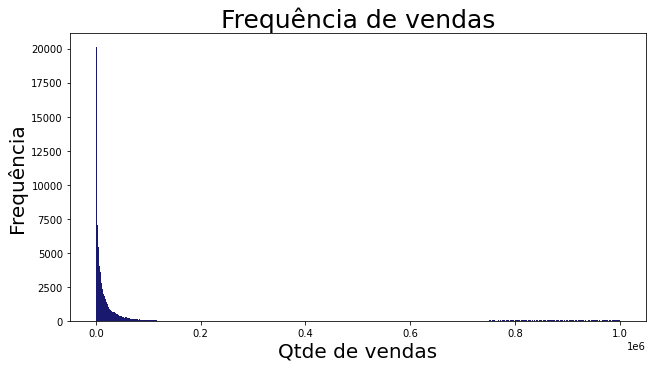

In [31]:
maximo = int(df3['vendas_semanais'].max())

# Cria o gráfico
fig = plt.figure( figsize = (8, 4))
ax = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de vendas', fontsize=25)
ax.set_xlabel('Qtde de vendas', fontsize=20)
ax.set_ylabel('Frequência', fontsize=20)

# Plota e mostra o gráfico
ax.hist(df3['vendas_semanais'], bins=range(0, maximo + 1001, 1000), color='midnightblue')
plt.show()

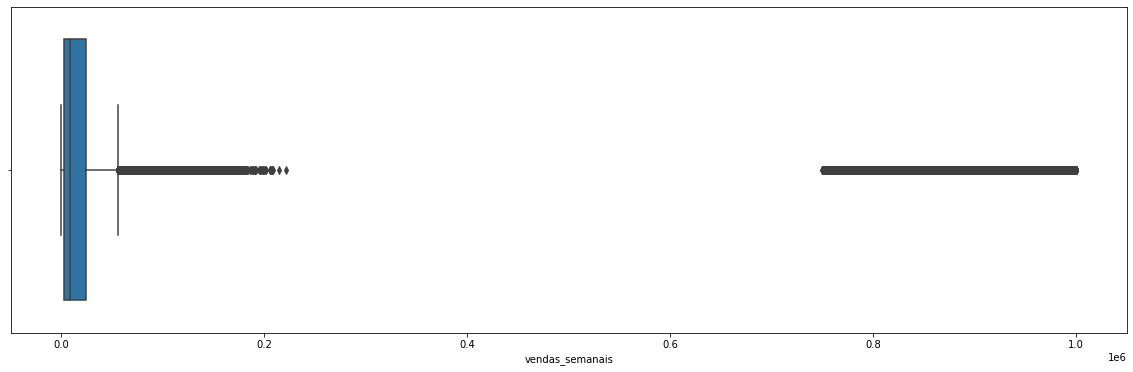

In [32]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x=df3['vendas_semanais'])
plt.show()

In [33]:
df3.head()

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto
0,140679,17,93,2023-01-07,6283.00,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.0
1,140696,17,16,2023-01-07,1641.25,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.0
2,140701,17,4,2023-01-07,39775.45,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.0
3,140733,17,14,2023-01-07,29555.43,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.0
4,140742,17,48,2023-01-07,414.00,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.0


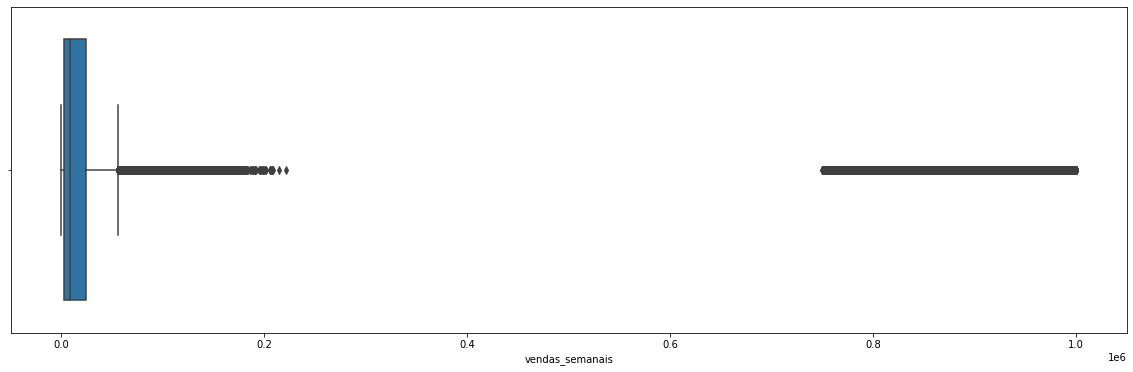

In [34]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
aux = df3[(df3['week_of_year'] != '45') | (df3['week_of_year'] != '46')]
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x=aux['vendas_semanais'])
plt.show()

##### 3.1.1.1. Análise de outliers

In [35]:
q1 = df3['vendas_semanais'].quantile(0.25)
q3 = df3['vendas_semanais'].quantile(0.75)

In [36]:
iqr = q3 - q1
iqr

21445.5425

In [37]:
limite_superior = q3 + 1.5 * iqr
limite_inferior = q1 - 1.5 * iqr

In [38]:
limite_superior

55898.396250000005

In [39]:
limite_inferior

-29883.77375

In [40]:
df3.loc[df3['vendas_semanais'] < 0, :]

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto


#### 3.1.2. Tamanho da loja

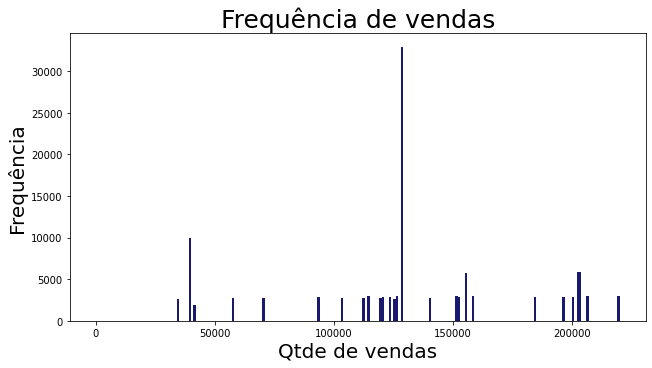

In [41]:
maximo = int(df3['tamanho'].max())

# Cria o gráfico
fig = plt.figure( figsize = (8, 4))
ax = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de vendas', fontsize=25)
ax.set_xlabel('Qtde de vendas', fontsize=20)
ax.set_ylabel('Frequência', fontsize=20)

# Plota e mostra o gráfico
ax.hist(df3['tamanho'], bins=range(0, maximo + 1001, 1000), color='midnightblue')
plt.show()

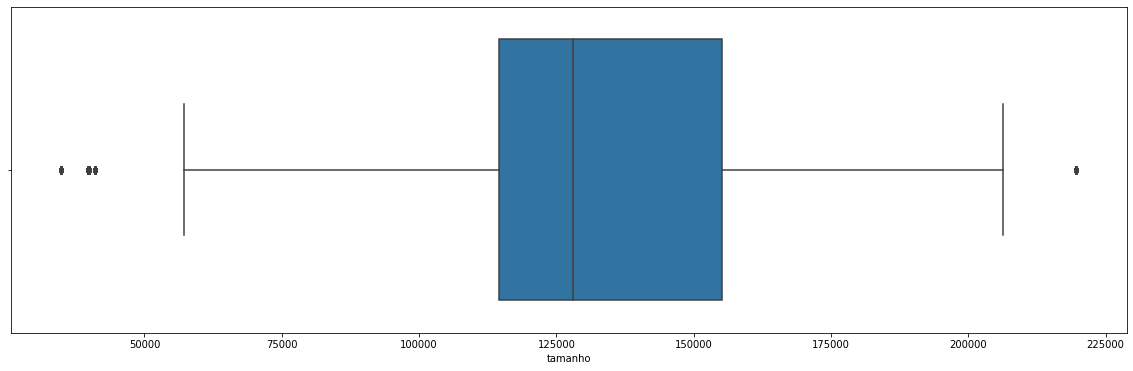

In [42]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x=df3['tamanho'])
plt.show()

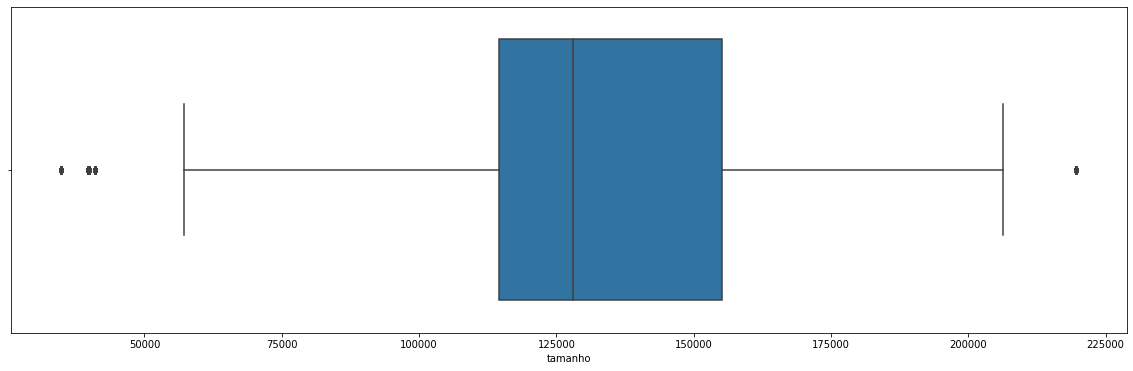

In [43]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x='tamanho', data=aux)
plt.show()

In [44]:
aux = df3.loc[df3['tamanho']!=df3['tamanho'].median(), :].reset_index()
aux

,index,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto
0,0,140679,17,93,2023-01-07,6283.00,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.00
1,1,140696,17,16,2023-01-07,1641.25,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.00
2,2,140701,17,4,2023-01-07,39775.45,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.00
3,3,140733,17,14,2023-01-07,29555.43,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.00
4,4,140742,17,48,2023-01-07,414.00,0,eletronico,93188.0,-14.316667,2.891,0.06866,300000.0,541,01,1,1,7,A,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89037,121991,275307,33,90,2023-11-18,23462.71,0,eletrodomestico,39690.0,15.710478,3.669,0.08010,1952.0,156,46,3,11,18,A,3313.45
89038,121992,275374,33,96,2023-11-18,10445.16,0,eletrodomestico,39690.0,15.710478,3.669,0.08010,1952.0,156,46,3,11,18,A,3313.45
89039,121993,275387,33,95,2023-11-18,25464.21,0,eletrodomestico,39690.0,15.710478,3.669,0.08010,1952.0,156,46,3,11,18,A,3313.45
89040,121994,275397,33,98,2023-11-18,7730.53,0,eletrodomestico,39690.0,15.710478,3.669,0.08010,1952.0,156,46,3,11,18,A,3313.45


In [45]:
aux2 = df3.loc[df3['tamanho']==df3['tamanho'].median(), :].reset_index()
aux2

,index,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto
0,5623,140681,3,25,2023-01-07,2658.57,0,eletronico,128107.0,11.861111,3.59723,0.07551,300000.0,901,01,1,1,7,B,0.00
1,5624,141029,3,20,2023-01-07,1358.81,0,eletronico,128107.0,11.861111,3.59723,0.07551,300000.0,901,01,1,1,7,B,0.00
2,5625,141077,3,34,2023-01-07,3280.50,0,eletronico,128107.0,11.861111,3.59723,0.07551,300000.0,901,01,1,1,7,B,0.00
3,5626,141106,3,23,2023-01-07,6530.88,0,eletronico,128107.0,11.861111,3.59723,0.07551,300000.0,901,01,1,1,7,B,0.00
4,5627,141169,3,19,2023-01-07,3113.76,0,eletronico,128107.0,11.861111,3.59723,0.07551,300000.0,901,01,1,1,7,B,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32949,120106,274985,11,71,2023-11-18,9419.43,0,eletrodomestico,128107.0,15.710478,3.59723,0.07197,17997.0,953,46,3,11,18,B,20716.44
32950,120107,274997,11,67,2023-11-18,9790.06,0,eletrodomestico,128107.0,15.710478,3.59723,0.07197,17997.0,953,46,3,11,18,B,20716.44
32951,120108,275011,11,79,2023-11-18,26994.74,0,eletrodomestico,128107.0,15.710478,3.59723,0.07197,17997.0,953,46,3,11,18,B,20716.44
32952,120109,275018,11,74,2023-11-18,18686.63,0,eletrodomestico,128107.0,15.710478,3.59723,0.07197,17997.0,953,46,3,11,18,B,20716.44


In [46]:
aux2['vendas_semanais'].std()

198997.56640053063

### 3.2. Análise bivariada

#### 3.2.1. Vendas por sazonalidade

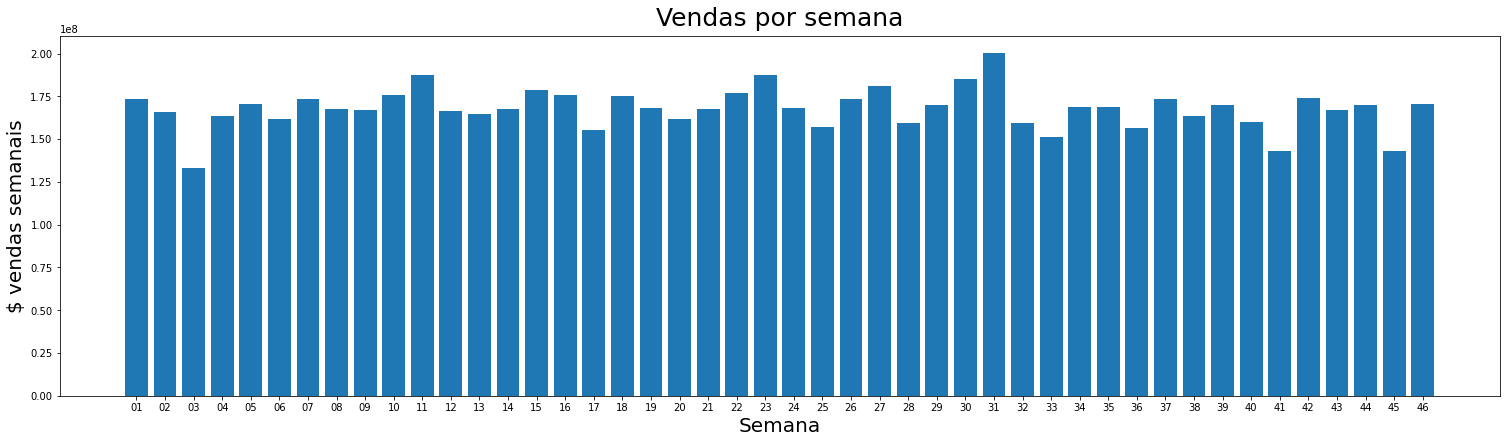

In [47]:
vendas_por_dia_da_semana = df3.groupby('week_of_year')['vendas_semanais'].sum().reset_index()
vendas_por_dia_da_semana.head()

# Cria o gráfico
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_dia_da_semana['vendas_semanais'])

# Configura o título e os eixos
ax.set_title('Vendas por semana', fontsize=25, pad=10)
ax.set_xlabel('Semana', fontsize=20)
ax.set_ylabel('$ vendas semanais', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_dia_da_semana['week_of_year'], vendas_por_dia_da_semana['vendas_semanais'])
plt.show()

#### 3.2.2. Vendas por tipo

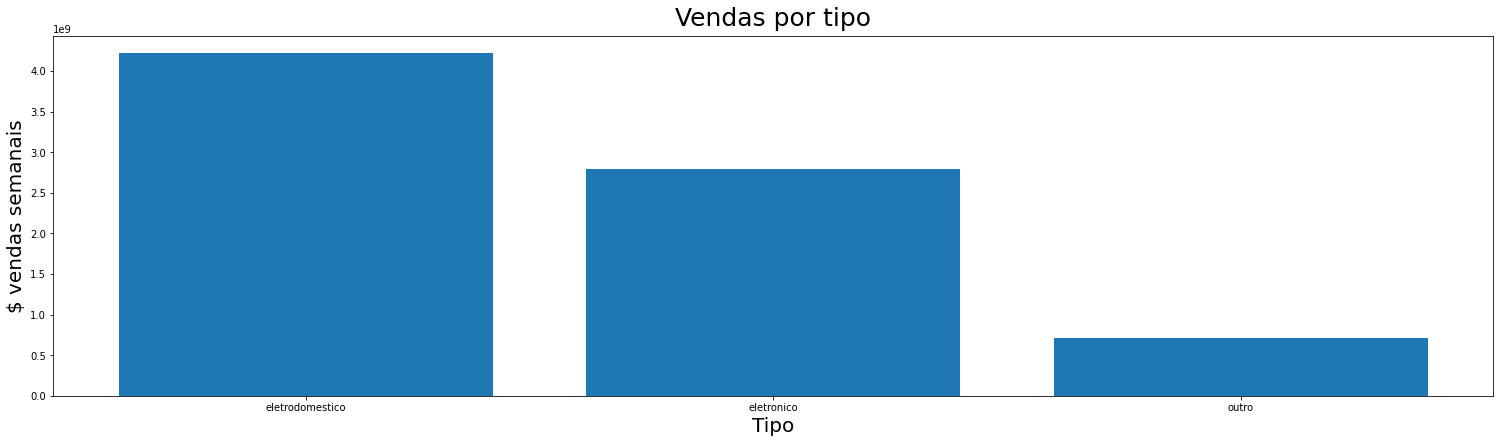

In [48]:
vendas_por_tipo = df2.loc[:, :].groupby('tipo').sum().reset_index()
vendas_por_tipo.head()

# Cria o gráfico
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_tipo['vendas_semanais'])

# Configura o título e os eixos
ax.set_title('Vendas por tipo', fontsize=25, pad=10)
ax.set_xlabel('Tipo', fontsize=20)
ax.set_ylabel('$ vendas semanais', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_tipo['tipo'], vendas_por_tipo['vendas_semanais'])
plt.show()

#### 3.2.3. Vendas por setor

In [49]:
df3['setor'].nunique()

80

In [50]:
loja_setor = df3.loc[:, ['loja', 'setor', 'vendas_semanais']].groupby(['loja', 'setor']).sum().reset_index()
loja_setor

,loja,setor,vendas_semanais
0,1,1,3.418771e+06
1,1,2,4.308632e+06
2,1,3,2.272300e+06
3,1,4,3.837845e+06
4,1,5,1.652245e+06
...,...,...,...
3170,45,93,1.067883e+06
3171,45,94,2.010327e+06
3172,45,95,4.763166e+06
3173,45,97,1.224273e+06


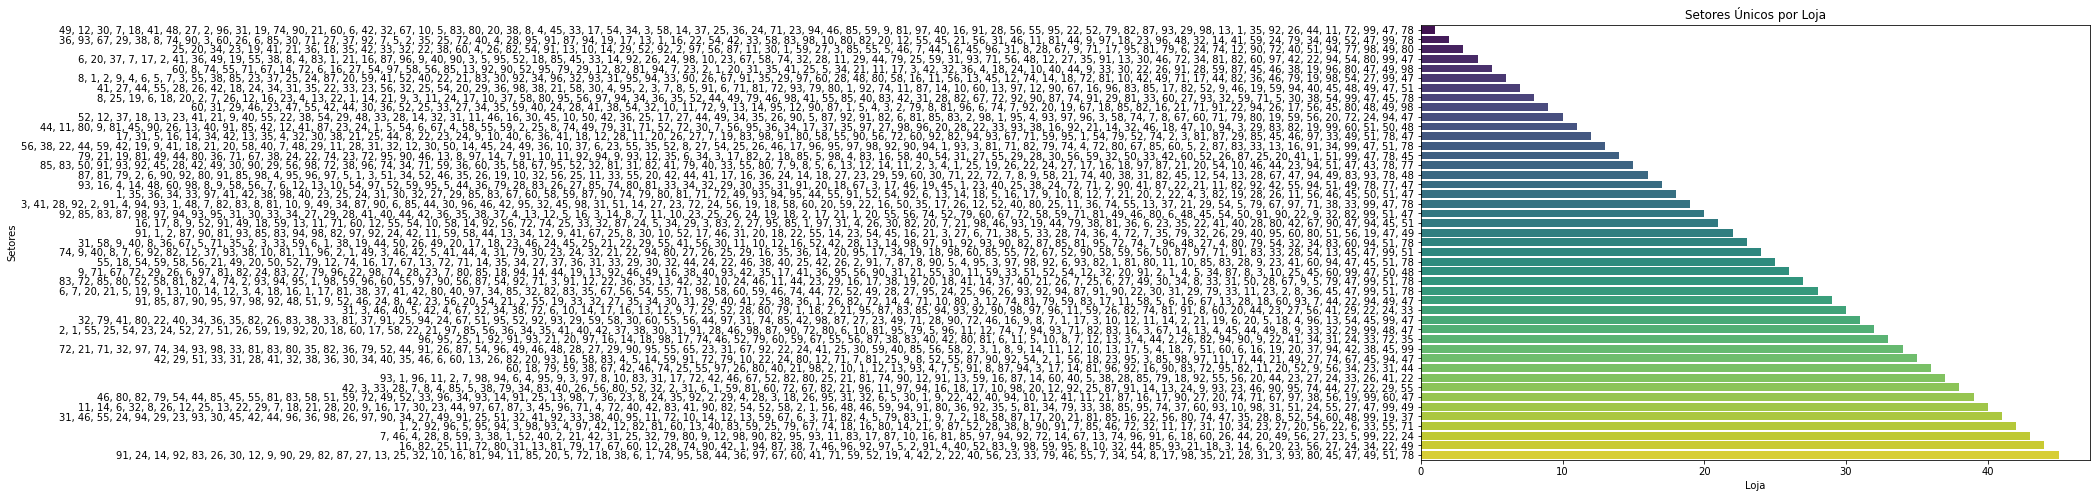

In [51]:
# Crie o DataFrame com os setores únicos por loja
setores_por_loja = df3.groupby('loja')['setor'].unique().reset_index()

# Converta os arrays de setores em strings
setores_por_loja['setor'] = setores_por_loja['setor'].apply(lambda x: ', '.join(map(str, x)))

# Crie o gráfico de barras empilhadas
plt.figure(figsize=(12, 8))
sns.barplot(x='loja', y='setor', data=setores_por_loja, palette='viridis')
plt.title('Setores Únicos por Loja')
plt.xlabel('Loja')
plt.ylabel('Setores')
plt.show()

In [52]:
setores_por_loja

,loja,setor
0,1,"49, 12, 30, 7, 18, 41, 48, 27, 2, 96, 31, 19, ..."
1,2,"36, 93, 67, 29, 38, 8, 74, 90, 3, 60, 26, 6, 8..."
2,3,"25, 20, 34, 23, 19, 41, 21, 36, 18, 35, 42, 33..."
3,4,"6, 20, 37, 7, 17, 2, 41, 36, 49, 19, 55, 38, 8..."
4,5,"60, 8, 74, 55, 71, 67, 14, 72, 6, 16, 27, 54, ..."
5,6,"8, 1, 2, 9, 4, 6, 5, 7, 3, 55, 38, 85, 23, 37,..."
6,7,"41, 27, 44, 55, 28, 26, 42, 18, 24, 34, 31, 35..."
7,8,"8, 25, 19, 6, 18, 20, 2, 7, 26, 12, 16, 23, 4,..."
8,9,"60, 31, 29, 46, 23, 47, 55, 42, 44, 30, 36, 52..."
9,10,"52, 12, 37, 18, 13, 23, 41, 21, 9, 40, 55, 22,..."


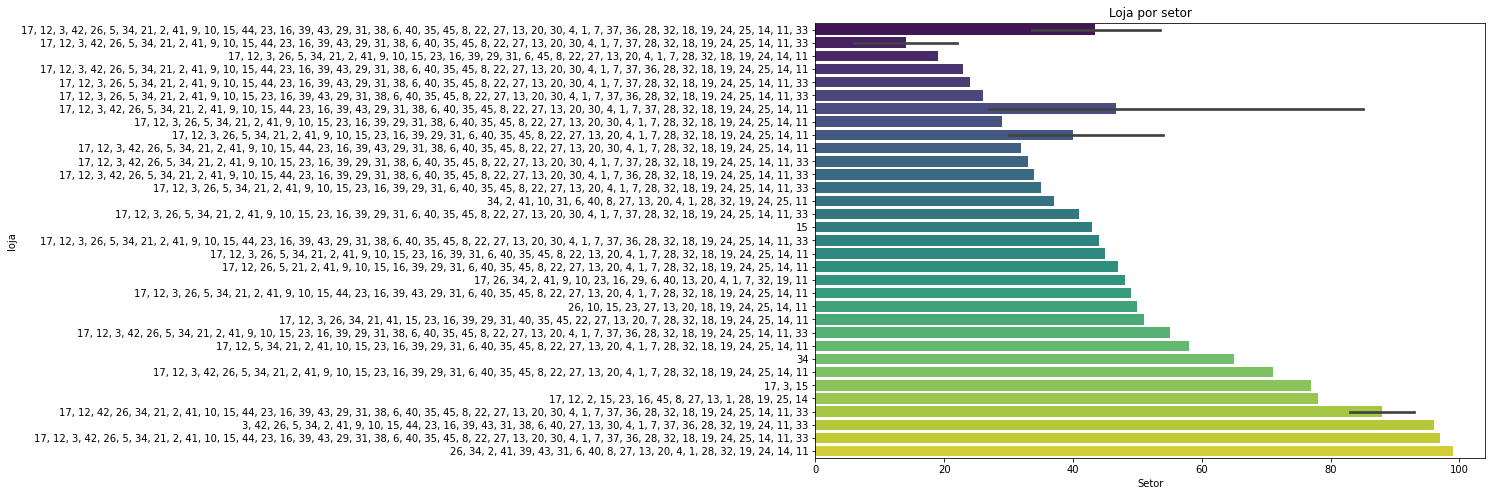

In [53]:
# Crie o DataFrame com os setores únicos por loja
setores_por_loja = df3.groupby('setor')['loja'].unique().reset_index()

# Converta os arrays de setores em strings
setores_por_loja['loja'] = setores_por_loja['loja'].apply(lambda x: ', '.join(map(str, x)))

# Crie o gráfico de barras empilhadas
plt.figure(figsize=(12, 8))
sns.barplot(x='setor', y='loja', data=setores_por_loja, palette='viridis')
plt.title('Loja por setor')
plt.xlabel('Setor')
plt.ylabel('loja')
plt.show()

In [54]:
# Crie o DataFrame com os setores únicos por loja
loja_por_setor = df3.groupby('setor')['loja'].unique().reset_index()
loja_por_setor['tamanho'] = loja_por_setor['loja'].apply(lambda x: len(x))

loja_por_setor = loja_por_setor.sort_values(by='tamanho', ascending=False)
loja_por_setor

,setor,loja,tamanho
0,1,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
75,95,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
72,92,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
37,40,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
39,42,"[17, 12, 3, 42, 26, 5, 34, 21, 2, 41, 9, 10, 1...",45
...,...,...,...
62,78,"[17, 12, 2, 15, 23, 16, 45, 8, 27, 13, 1, 28, ...",15
47,50,"[26, 10, 15, 23, 27, 13, 20, 18, 19, 24, 25, 1...",13
61,77,"[17, 3, 15]",3
56,65,[34],1


In [55]:
setores_a = df3[(df3['setor'] == 78) | (df3['setor'] == 77) | (df3['setor'] == 65)]
setores_b = df3[(df3['setor'] != 78) & (df3['setor'] != 77) & (df3['setor'] != 65)]

In [56]:
feriado = df3[(df3['feriado'] == 1)]

In [57]:
feriado

,id,loja,setor,data,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_year,week_of_month,month,day,tipo_de_loja,desconto
315,155379,17,79,2023-02-11,25105.35000,1,eletronico,93188.0,-9.894444,3.03400,0.06866,300000.0,955,06,2,2,11,A,0.0
316,155402,17,10,2023-02-11,11108.77000,1,eletronico,93188.0,-9.894444,3.03400,0.06866,300000.0,955,06,2,2,11,A,0.0
317,155423,17,11,2023-02-11,10865.32000,1,eletronico,93188.0,-9.894444,3.03400,0.06866,300000.0,955,06,2,2,11,A,0.0
318,155469,17,14,2023-02-11,11772.51000,1,eletronico,93188.0,-9.894444,3.03400,0.06866,300000.0,955,06,2,2,11,A,0.0
319,155491,17,67,2023-02-11,12433.79000,1,eletronico,93188.0,-9.894444,3.03400,0.06866,300000.0,955,06,2,2,11,A,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121573,246350,33,3,2023-09-09,269.44000,1,eletrodomestico,39690.0,15.710478,3.59723,0.08442,300000.0,319,36,2,9,9,A,0.0
121574,246417,33,5,2023-09-09,240.00000,1,eletrodomestico,39690.0,15.710478,3.59723,0.08442,300000.0,319,36,2,9,9,A,0.0
121575,246465,33,8,2023-09-09,864992.08012,1,eletrodomestico,39690.0,15.710478,3.59723,0.08442,300000.0,319,36,2,9,9,A,0.0
121576,246469,33,83,2023-09-09,2962.29000,1,eletrodomestico,39690.0,15.710478,3.59723,0.08442,300000.0,319,36,2,9,9,A,0.0


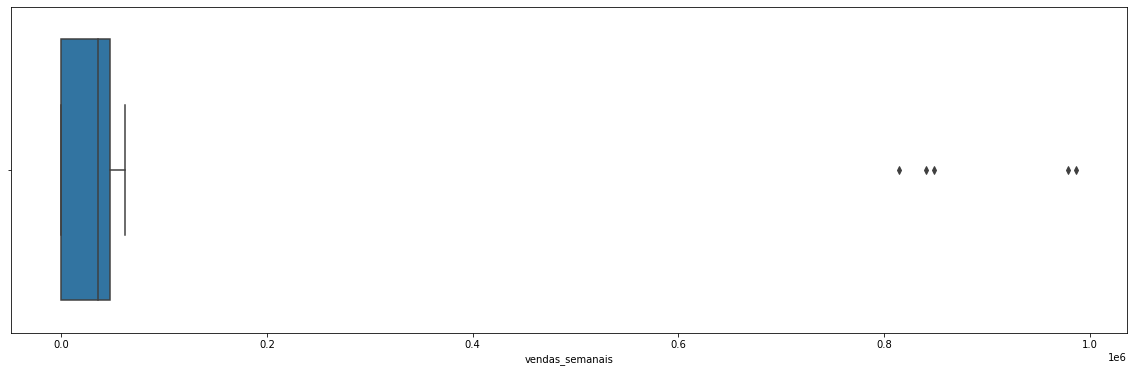

In [58]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x=setores_a['vendas_semanais'])
plt.show()

In [59]:
# Crie o DataFrame com os setores únicos por loja
setores_por_loja = df3.groupby('loja')['setor'].unique().reset_index()
setores_por_loja['tamanho'] = setores_por_loja['setor'].apply(lambda x: len(x))

setores_por_loja = setores_por_loja.sort_values(by='tamanho', ascending=False)
setores_por_loja

,loja,setor,tamanho
18,19,"[3, 41, 28, 92, 2, 91, 4, 94, 93, 1, 48, 7, 82...",77
12,13,"[56, 38, 22, 44, 59, 42, 19, 9, 41, 18, 21, 20...",77
10,11,"[44, 11, 80, 9, 81, 45, 90, 26, 13, 40, 91, 85...",76
14,15,"[85, 83, 50, 91, 93, 92, 45, 28, 42, 49, 30, 9...",76
0,1,"[49, 12, 30, 7, 18, 41, 48, 27, 2, 96, 31, 19,...",75
40,41,"[31, 46, 55, 24, 94, 29, 23, 93, 30, 45, 42, 4...",75
33,34,"[72, 21, 71, 32, 97, 74, 34, 93, 98, 33, 81, 8...",75
31,32,"[2, 1, 55, 25, 54, 23, 24, 52, 27, 51, 26, 59,...",75
27,28,"[6, 7, 20, 21, 5, 19, 9, 13, 10, 14, 12, 3, 4,...",75
26,27,"[83, 72, 85, 80, 52, 58, 81, 82, 4, 74, 2, 93,...",75


In [60]:
# Crie o DataFrame com os setores únicos por loja
setores_por_loja = df3.groupby('loja')['setor'].unique().reset_index()

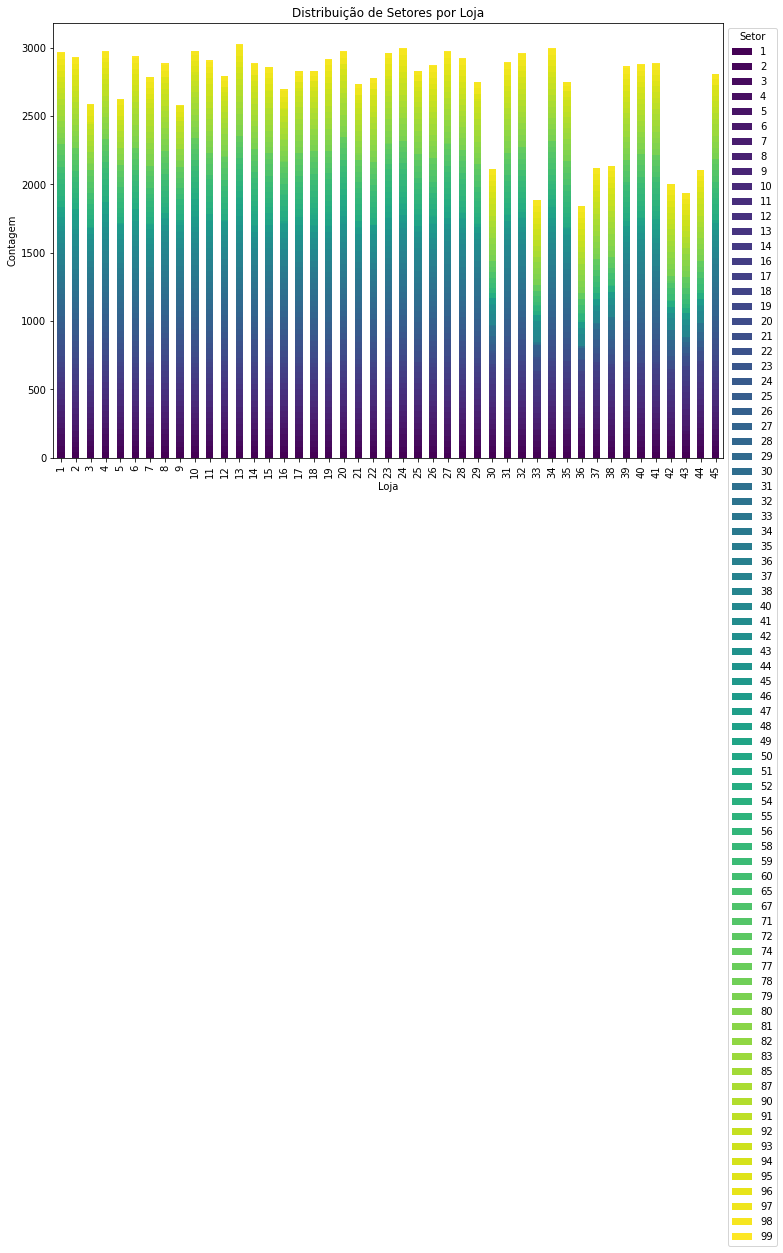

In [61]:
# Crie o DataFrame com os setores por loja
setores_por_loja = df3.groupby(['loja', 'setor']).size().unstack(fill_value=0).reset_index()

# Crie o gráfico de barras empilhadas
plt.figure(figsize=(12, 8))
setores_por_loja.plot(x='loja', kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Distribuição de Setores por Loja')
plt.xlabel('Loja')
plt.ylabel('Contagem')
plt.legend(title='Setor', bbox_to_anchor=(1, 1))
plt.show()

In [62]:
setores_por_loja = df3.groupby('loja')['setor'].unique().reset_index()
setores_por_loja

,loja,setor
0,1,"[49, 12, 30, 7, 18, 41, 48, 27, 2, 96, 31, 19,..."
1,2,"[36, 93, 67, 29, 38, 8, 74, 90, 3, 60, 26, 6, ..."
2,3,"[25, 20, 34, 23, 19, 41, 21, 36, 18, 35, 42, 3..."
3,4,"[6, 20, 37, 7, 17, 2, 41, 36, 49, 19, 55, 38, ..."
4,5,"[60, 8, 74, 55, 71, 67, 14, 72, 6, 16, 27, 54,..."
5,6,"[8, 1, 2, 9, 4, 6, 5, 7, 3, 55, 38, 85, 23, 37..."
6,7,"[41, 27, 44, 55, 28, 26, 42, 18, 24, 34, 31, 3..."
7,8,"[8, 25, 19, 6, 18, 20, 2, 7, 26, 12, 16, 23, 4..."
8,9,"[60, 31, 29, 46, 23, 47, 55, 42, 44, 30, 36, 5..."
9,10,"[52, 12, 37, 18, 13, 23, 41, 21, 9, 40, 55, 22..."


In [63]:
setor_por_dia = df3.groupby(['data', 'setor'])['vendas_semanais'].mean().reset_index()
setor_por_dia

,data,setor,vendas_semanais
0,2023-01-07,1,113848.322764
1,2023-01-07,2,117859.230165
2,2023-01-07,3,98052.430083
3,2023-01-07,4,108155.796432
4,2023-01-07,5,19486.681500
...,...,...,...
3523,2023-11-18,95,117727.448794
3524,2023-11-18,96,44741.036193
3525,2023-11-18,97,36963.819438
3526,2023-11-18,98,28005.871625


In [64]:
setor_por_loja = df3.loc[:, :].groupby(['loja', 'setor']).mean().reset_index()
setor_por_loja

,loja,setor,id,vendas_semanais,feriado,tamanho,temperatura,combustivel,desemprego,distancia_competidores,clientes,week_of_month,month,day,desconto
0,1,1,205790.452381,81399.319079,0.047619,151315.0,18.699362,3.507035,0.077988,286437.476190,525.904762,2.619048,5.738095,15.190476,915.907857
1,1,2,210119.209302,100200.747157,0.046512,151315.0,19.170193,3.501760,0.078185,286752.883721,540.651163,2.651163,6.069767,15.395349,894.607674
2,1,3,209498.488889,50495.563455,0.044444,151315.0,19.428403,3.508321,0.078124,287341.644444,524.355556,2.666667,6.022222,15.488889,854.847333
3,1,4,206484.045455,87223.757548,0.045455,151315.0,19.285516,3.515084,0.078062,287053.954545,541.363636,2.636364,5.795455,15.181818,874.275682
4,1,5,207830.150000,41306.130201,0.050000,151315.0,19.615643,3.519656,0.078195,292980.350000,538.925000,2.775000,5.875000,16.200000,641.792000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,45,93,210679.400000,26697.084419,0.050000,128107.0,15.193790,3.658429,0.085595,286341.200000,458.950000,2.625000,6.125000,15.250000,1193.488750
3171,45,94,208626.780488,49032.376785,0.048780,128107.0,15.555308,3.651589,0.085593,286674.341463,437.731707,2.536585,5.975610,14.707317,1164.379268
3172,45,95,210291.341463,116174.782757,0.024390,128107.0,16.885901,3.682418,0.085604,286674.341463,455.658537,2.682927,6.097561,15.414634,1164.379268
3173,45,97,205442.333333,31391.604409,0.051282,128107.0,15.661564,3.652177,0.085585,292472.000000,470.641026,2.692308,5.692308,15.666667,303.285897


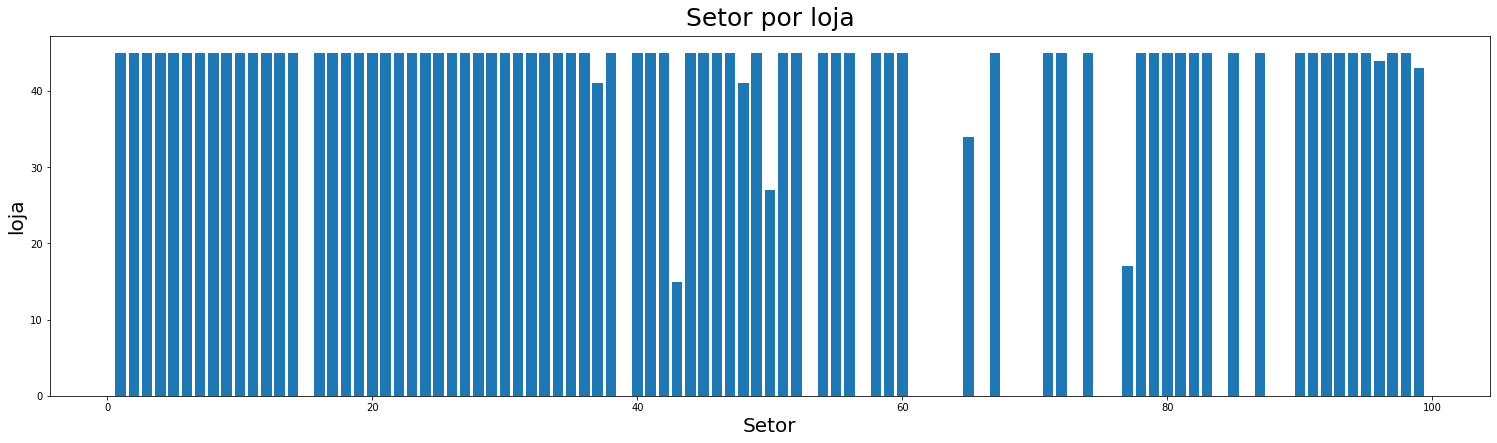

In [65]:
# Cria o gráfico
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

# Configura o título e os eixos
ax.set_title('Setor por loja', fontsize=25, pad=10)
ax.set_xlabel('Setor', fontsize=20)
ax.set_ylabel('loja', fontsize=20)

# Plota e mostra o gráfico
ax.bar(setor_por_loja['setor'], setor_por_loja['loja'])
plt.show()

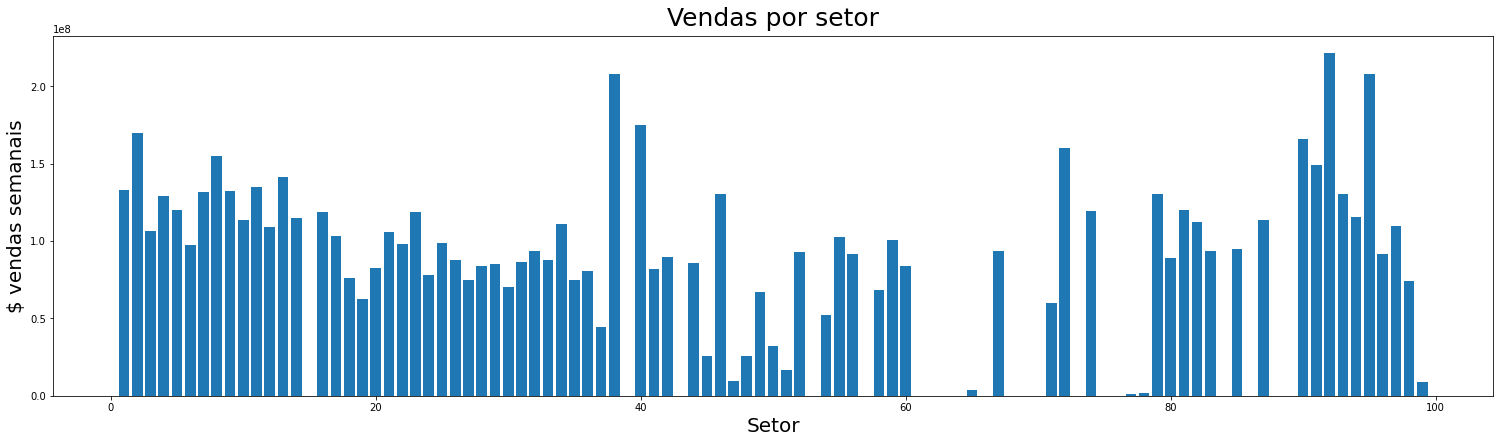

In [66]:
vendas_por_setor = df2.loc[:, :].groupby('setor').sum().reset_index()
vendas_por_setor.head()

# Cria o gráfico
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_setor['vendas_semanais'])

# Configura o título e os eixos
ax.set_title('Vendas por setor', fontsize=25, pad=10)
ax.set_xlabel('Setor', fontsize=20)
ax.set_ylabel('$ vendas semanais', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_setor['setor'], vendas_por_setor['vendas_semanais'])
plt.show()

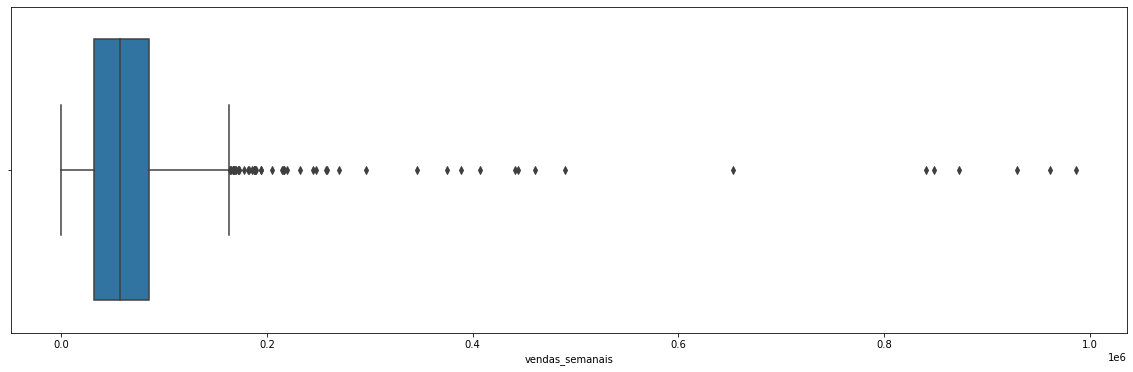

In [67]:
# Criando o boxplot com seaborn e ajustando o tamanho da figura
plt.figure(figsize=(20, 6))  # Defina o tamanho desejado, por exemplo, (largura, altura)
sns.boxplot(x=setor_por_dia['vendas_semanais'])
plt.show()

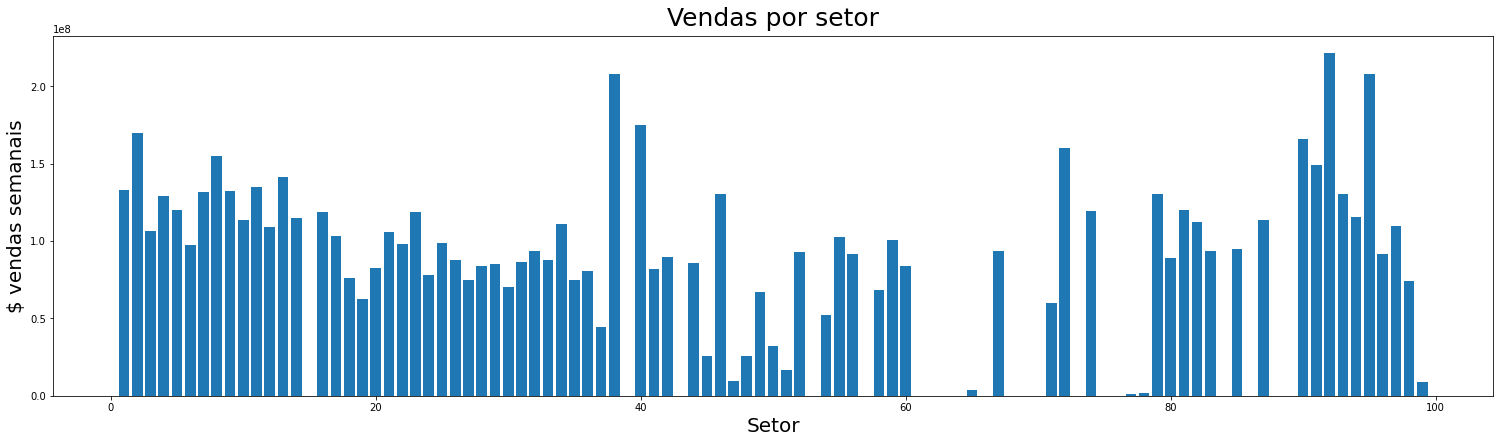

In [68]:
vendas_por_setor = df2.loc[:, :].groupby('setor').sum().reset_index()
vendas_por_setor.head()

# Cria o gráfico
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_setor['vendas_semanais'])

# Configura o título e os eixos
ax.set_title('Vendas por setor', fontsize=25, pad=10)
ax.set_xlabel('Setor', fontsize=20)
ax.set_ylabel('$ vendas semanais', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_setor['setor'], vendas_por_setor['vendas_semanais'])
plt.show()

#### 3.2.4. Vendas por clientes

In [69]:
test_features
test_features.loc[test_features['clientes'] < 20]

,loja,data,temperatura,combustivel,desconto_1,desconto_2,desconto_3,desconto_4,desconto_5,desemprego,feriado,distancia_competidores,clientes
3,21,11-25,13.572222,3.236,233.85,206.36,40561.80,319.19,170.64,0.07441,sim,5297.0,1
125,3,12-09,9.588889,3.158,4059.38,6.47,123.42,833.44,3018.08,0.07197,nao,10101.0,16
157,44,12-16,-2.305556,3.282,29.40,NaN,6.75,NaN,1041.62,0.06078,nao,4017.0,8


In [70]:
test_features.shape

(270, 13)

In [71]:
test

,id,loja,setor,data,feriado
0,276064,20,16,11-25,sim
1,276065,39,14,11-25,sim
2,276066,40,5,11-25,sim
3,276067,24,92,11-25,sim
4,276068,22,20,11-25,sim
...,...,...,...,...,...
18063,294127,11,94,12-30,sim
18064,294128,15,18,12-30,sim
18065,294129,11,30,12-30,sim
18066,294130,37,46,12-30,sim


#### 3.2.5. Vendas por semana

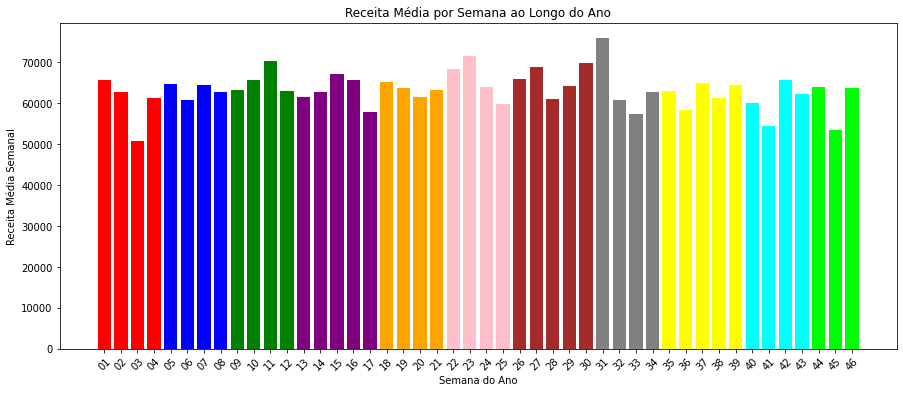

In [72]:
df = df3.copy()
# Adicione a coluna 'mes' ao DataFrame
df['mes'] = df['data'].dt.month

# Criar uma coluna de semana para agrupar as barras
df['week_of_year'] = df['data'].dt.strftime('%U')

# Calcular a média da receita para cada semana (ou qualquer outra métrica desejada)
df_semanal = df.groupby(['week_of_year', 'mes'])['vendas_semanais'].mean().reset_index()

# Plotar o gráfico de barras
plt.figure(figsize=(15, 6))

# Destacar as semanas que representam o início de cada mês
cores = df_semanal['mes'].map({1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange', 6: 'pink', 7: 'brown', 8: 'grey', 9: 'yellow', 10: 'cyan', 11: 'lime', 12: 'black'})
plt.bar(df_semanal['week_of_year'], df_semanal['vendas_semanais'], color=cores)

plt.xlabel('Semana do Ano')
plt.ylabel('Receita Média Semanal')
plt.title('Receita Média por Semana ao Longo do Ano')
plt.xticks(rotation=45)
plt.show()

### 3.1. Análise Multivariada

#### 3.1.1. Profile

In [73]:
#profile = ydata_profiling.ProfileReport(df3, minimal=False)

#profile = df3.profile_report(
#    correlations={
#        "pearson": {"calculate": True},
#        "spearman": {"calculate": True},
#        "kendall": {"calculate": True},
#        "cramers": {"calculate": True},
#        "phi_k": {"calculate": False},
#    },)

In [74]:
#profile

#### 3.1.2. HeatMap

C:\Users\paula\AppData\Local\Temp\ipykernel_16344\1603569551.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
C:\Users\paula\AppData\Local\Temp\ipykernel_16344\1603569551.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


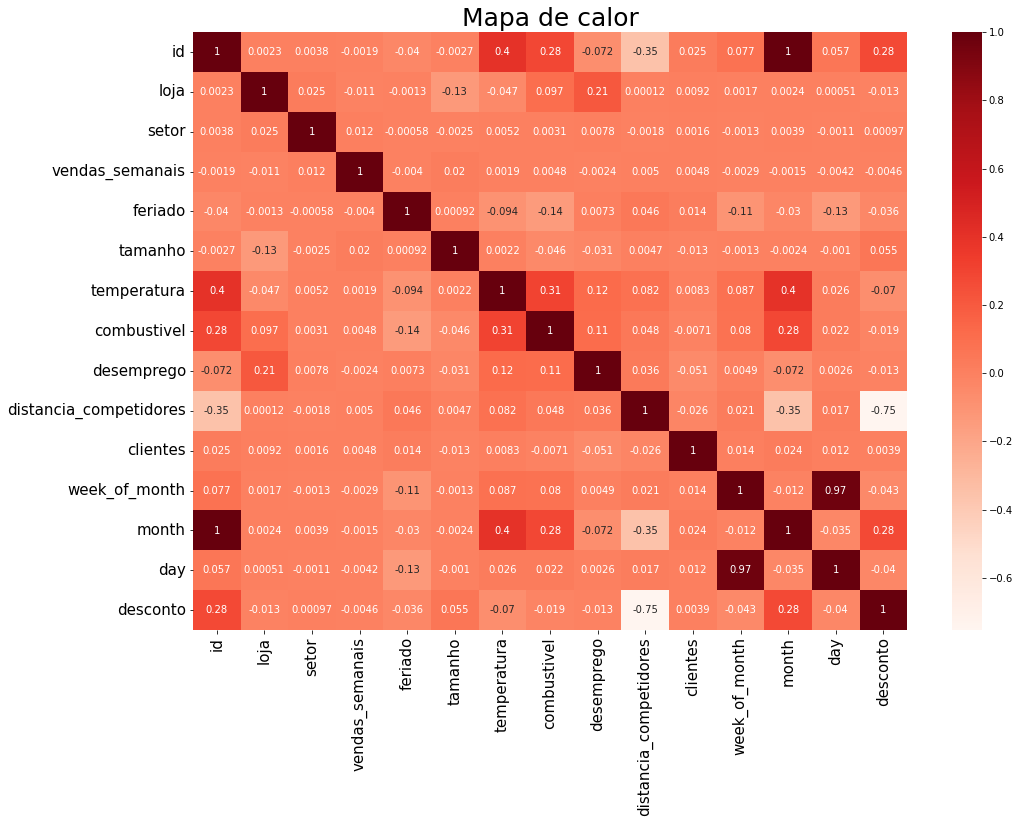

In [75]:
# Criar o mapa de calor
corr = df3.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Reds', ax=ax)
plt.show()

# III. Preparação dos dados

## 4. DATA PREPARATION

In [76]:
df4 = df3.copy()
df4['week_of_year'] = df4['week_of_year'].astype(int)
df4.columns

Index(['id', 'loja', 'setor', 'data', 'vendas_semanais', 'feriado', 'tipo',
       'tamanho', 'temperatura', 'combustivel', 'desemprego',
       'distancia_competidores', 'clientes', 'week_of_year', 'week_of_month',
       'month', 'day', 'tipo_de_loja', 'desconto'],
      dtype='object')

### 4.1 Rescala de Variáveis Numéricas

In [77]:
mm = pp.MinMaxScaler()   # Mantem a mesma distribuição, com outro shape, e colocando de 0 a 1
ss = pp.StandardScaler() # Rescala os dados
rs = pp.RobustScaler()

df4['tamanho']      = ss.fit_transform(df4[['tamanho']])
df4['temperatura']  = ss.fit_transform(df4[['temperatura']])

df4['desconto']     = mm.fit_transform(df4[['desconto']])
df4['week_of_year'] = mm.fit_transform(df4[['week_of_year']])
df4['clientes']     = mm.fit_transform(df4[['clientes']])

df4['distancia_competidores'] = rs.fit_transform(df4[['distancia_competidores']])

### 4.2 Encodar Variáveis Categóricas

In [78]:
#'feriado' - One Hot Encoding
df4 = pd.get_dummies(df4,prefix=['feriado'],dtype='int64',columns=['feriado'])

#'tipo' - Label Encoding
le = pp.LabelEncoder()
df4['tipo'] = le.fit_transform(df4['tipo'])

#'tipo_de_loja' - One Hot Encoding
df4 = pd.get_dummies(df4,prefix=['tipo_de_loja'],dtype='int64',columns=['tipo_de_loja'])

# Encoding para week_of_month
df4['week_of_month_sin'] = df4['week_of_month'].apply(lambda x: np.sin(x * (2 * np.pi / 4))) 
df4['week_of_month_cos'] = df4['week_of_month'].apply(lambda x: np.cos(x * (2 * np.pi / 4)))
df4 = df4.drop(['week_of_month'],axis=1)

# Encoding para day
df4['day_sin'] = df4['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30))) 
df4['day_cos'] = df4['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
df4 = df4.drop(['day'],axis=1)

### 4.3 Normalização do Fenômeno

In [79]:
df4['vendas_semanais'] = np.log1p(df4['vendas_semanais'])

In [80]:
df4['vendas_semanais'].describe()

count    121996.000000
mean          8.788319
std           2.277845
min           0.693147
25%           7.734358
50%           9.025337
75%          10.074541
max          13.815479
Name: vendas_semanais, dtype: float64

## 5. FEATURE SELECTION

In [81]:
df5 = df4.copy()

In [82]:
x_train_n = df5.drop(['id', 'vendas_semanais', 'data'], axis=1)
y_train_n = df5['vendas_semanais']

### 5.1. Feature Importance

In [83]:
# Model definition
forest = en.ExtraTreesRegressor(n_estimators=100, random_state=0, n_jobs=-1)
forest.fit(x_train_n, y_train_n)

ExtraTreesRegressor(n_jobs=-1, random_state=0)

Feature Ranking
                  feature  importance
0                   setor    0.549072
0                 tamanho    0.049808
0                    tipo    0.048196
0                clientes    0.039146
0             temperatura    0.038042
0                    loja    0.035729
0             combustivel    0.034871
0              desemprego    0.033885
0            week_of_year    0.032879
0                   month    0.029254
0                 day_sin    0.026516
0                 day_cos    0.025797
0       week_of_month_sin    0.014257
0          tipo_de_loja_A    0.013916
0       week_of_month_cos    0.013824
0                desconto    0.002909
0  distancia_competidores    0.002765
0          tipo_de_loja_B    0.002500
0               feriado_1    0.002440
0               feriado_0    0.002432
0          tipo_de_loja_C    0.001762


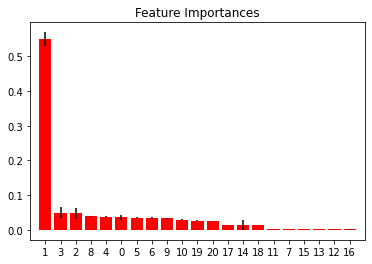

In [84]:
importances = forest.feature_importances_      # Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]        # Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

### 5.2. Definir o período de datas

In [85]:
# Definir as datas
data_inicial = datetime.strptime('2023-01-07', '%Y-%m-%d')
data_final   = datetime.strptime('2023-11-18', '%Y-%m-%d')

# Calcular a diferença em dias
diferenca_dias = (data_final - data_inicial).days

# Calcular 80% da diferença em dias
dias_limite = diferenca_dias * 0.8

# Somar a data inicial com os dias limite
data_limite = data_inicial + timedelta(days=dias_limite)

# Exibir a data limite
print(f'A data limite é: {data_limite.strftime("%Y-%m-%d")}')

A data limite é: 2023-09-16


In [86]:
# Definir os limites de datas
limite_data_teste = '2023-09-16'

# Definir o dataset de treino
X_train_full_FUll = df5.copy()
Y_train_full      = X_train_full_FUll['vendas_semanais']

# Definir o dataset de treino
X_train_full      = df5[df5['data'] < limite_data_teste]
Y_train           = X_train_full['vendas_semanais']

# Definir o dataset de teste
X_test_full       = df5[df5['data'] >= limite_data_teste]
Y_test            = X_test_full['vendas_semanais']

# Exibir os limites de datas
min_xtrain        = X_train_full['data'].min()
max_xtrain        = X_train_full['data'].max()

min_xtest         = X_test_full['data'].min()
max_xtest         = X_test_full['data'].max()

print(f'Limites do X_train: {min_xtrain} - {max_xtrain}')
print(f'Limites do X_test: {min_xtest} - {max_xtest}')

Limites do X_train: 2023-01-07 00:00:00 - 2023-09-09 00:00:00
Limites do X_test: 2023-09-16 00:00:00 - 2023-11-18 00:00:00


# IV. Modelagem

## 6. MACHINE LEARNING MODELING

In [87]:
X_train = X_train_full.drop(['id', 'vendas_semanais', 'data'], axis=1)
X_test  = X_test_full.drop(['id', 'vendas_semanais', 'data'], axis=1)

### 6.1. Treinar, testar e medir

#### 6.1.1 Linear Regression

In [88]:
%%time
# Criar uma instância do modelo de regressão linear
modelo_regressao = LinearRegression()

# Treinar o modelo com os dados de treinamento
modelo_regressao.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes = modelo_regressao.predict(X_test)

# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 202273.69256440614
CPU times: total: 219 ms
Wall time: 226 ms


In [89]:
lr_cv = cross_validation(X_train_full, 5, 'Linear Regression', modelo_regressao, verbose=True)
lr_cv

K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,RSME CV
0,Linear Regression,208397.91 +/- 1253.01


#### 6.1.2 Lasso

In [90]:
%%time
# Criar uma instância do modelo Lasso
modelo_lasso = Lasso(alpha=1.0, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_lasso.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_lasso = modelo_lasso.predict(X_test)

# Calcular o RMSE
rmse_lasso = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_lasso)))
print(f"Root Mean Squared Error (RMSE) para Regressão Lasso: {rmse_lasso}")

Root Mean Squared Error (RMSE) para Regressão Lasso: 202701.18127561567
CPU times: total: 156 ms
Wall time: 113 ms


In [91]:
%%time
lasso_cv = cross_validation(X_train_full,5,'Linear Regression - Lasso',modelo_lasso,verbose=True)
lasso_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 828 ms
Wall time: 487 ms


,Model Name,RSME CV
0,Linear Regression - Lasso,208847.92 +/- 1230.44


#### 6.1.3 Random Forest

In [92]:
%%time
# Criar uma instância do modelo de Random Forest
modelo_random_forest = en.RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Treinar o modelo com os dados de treinamento
modelo_random_forest.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_rf = modelo_random_forest.predict(X_test)

# Calcular o RMSE
rmse_rf = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_rf)))
print(f"Root Mean Squared Error (RMSE) para Random Forest: {rmse_rf}")

Root Mean Squared Error (RMSE) para Random Forest: 198268.2769354889
CPU times: total: 1min 58s
Wall time: 17.3 s


In [106]:
%%time
rf_cv = cross_validation(X_train_full,5,'Random Forest',modelo_random_forest,verbose=True)
rf_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 3min 55s
Wall time: 35.8 s


,Model Name,RSME CV
0,Random Forest,205103.3 +/- 1315.44


#### 6.1.4 XGBoost

In [93]:
%%time
# Criar uma instância do modelo XGBoost
modelo_xgboost = XGBRegressor(n_estimators=100, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_xgboost.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_xgboost = modelo_xgboost.predict(X_test)

# Calcular o RMSE
rmse_xgboost = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_xgboost)))
print(f"Root Mean Squared Error (RMSE) para XGBoost: {rmse_xgboost}")

Root Mean Squared Error (RMSE) para XGBoost: 198894.41303392552
CPU times: total: 23.8 s
Wall time: 3.76 s


In [94]:
%%time
xgb_cv = cross_validation(X_train_full,5,'XGBoost',modelo_xgboost,verbose=True)
xgb_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 55.6 s
Wall time: 8.73 s


,Model Name,RSME CV
0,XGBoost,206824.68 +/- 2026.73


#### 6.1.5 LGBM Model

In [95]:
%%time
# Criar uma instância do modelo LightGBM
modelo_lgbm = LGBMRegressor(n_estimators=100, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_lgbm.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_lgbm = modelo_lgbm.predict(X_test)

# Calcular o RMSE
rmse_lgbm = np.sqrt(mean_squared_error(np.expm1(Y_test),np.expm1( previsoes_lgbm)))
print(f"Root Mean Squared Error (RMSE) para LightGBM: {rmse_lgbm}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 95385, number of used features: 19
[LightGBM] [Info] Start training from score 8.787567
Root Mean Squared Error (RMSE) para LightGBM: 199271.3479651534
CPU times: total: 2.86 s
Wall time: 2.14 s


In [96]:
%%time
lgbm_cv = cross_validation(X_train_full,5,'LGBM Model',modelo_lgbm,verbose=True)
lgbm_cv

K = 5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 13211, number of used features: 17
[LightGBM] [Info] Start training from score 8.684756
K = 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 29213, number of used features: 19
[LightGBM] [Info] Start training from score 8.760524
K = 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004441 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

,Model Name,RSME CV
0,LGBM Model,205630.23 +/- 1231.93


#### 6.1.6 Elastic Net

In [97]:
%%time
# Criar uma instância do modelo Elastic Net
modelo_elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_elasticnet.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_elasticnet = modelo_elasticnet.predict(X_test)

# Calcular o RMSE
rmse_elasticnet = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_elasticnet)))
print(f"Root Mean Squared Error (RMSE) para Elastic Net: {rmse_elasticnet}")

Root Mean Squared Error (RMSE) para Elastic Net: 202684.0419498248
CPU times: total: 125 ms
Wall time: 110 ms


In [98]:
%%time
elastic_cv = cross_validation(X_train_full,5,'Elastic Net',modelo_elasticnet,verbose=True)
elastic_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 844 ms
Wall time: 463 ms


,Model Name,RSME CV
0,Elastic Net,208830.75 +/- 1230.47


#### 6.1.8 K-Nearest Neighbors (KNN) Regression

In [99]:
%%time
# Criar uma instância do modelo KNN Regressor
modelo_knn = KNeighborsRegressor(n_neighbors=7)  # O número de vizinhos (n_neighbors) é um exemplo, ajuste conforme necessário

# Treinar o modelo com os dados de treinamento
modelo_knn.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_knn = modelo_knn.predict(X_test)

# Calcular o RMSE
rmse_knn = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_knn)))
print(f"Root Mean Squared Error (RMSE) para K-Nearest Neighbors Regression: {rmse_knn}")

Root Mean Squared Error (RMSE) para K-Nearest Neighbors Regression: 199835.93320336434
CPU times: total: 1min 26s
Wall time: 1min 46s


In [100]:
%%time
knn_cv = cross_validation(X_train_full,5,'KNN',modelo_knn,verbose=True)
knn_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 2min 40s
Wall time: 2min 55s


,Model Name,RSME CV
0,KNN,206201.62 +/- 1230.22


#### 6.1.9 Ridge

In [101]:
%%time
# Criar uma instância do modelo Ridge
modelo_ridge = Ridge(alpha=1.0, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_ridge.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_ridge = modelo_ridge.predict(X_test)

# Calcular o RMSE
rmse_ridge = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_ridge)))
print(f"Root Mean Squared Error (RMSE) para Ridge Regression: {rmse_ridge}")

Root Mean Squared Error (RMSE) para Ridge Regression: 202271.9688272989
CPU times: total: 109 ms
Wall time: 117 ms


In [102]:
%%time
ridge_cv = cross_validation(X_train_full,5,'Ridge',modelo_ridge,verbose=True)
ridge_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 828 ms
Wall time: 477 ms


,Model Name,RSME CV
0,Ridge,208394.03 +/- 1258.27


#### 6.1.10 Gradient Boosting Regressor

In [103]:
%%time
# Criar uma instância do modelo Gradient Boosting Regressor
modelo_gradient_boosting = GradientBoostingRegressor(n_estimators=250, random_state=42)

# Treinar o modelo com os dados de treinamento
modelo_gradient_boosting.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
previsoes_gradient_boosting = modelo_gradient_boosting.predict(X_test)

# Calcular o RMSE
rmse_gradient_boosting = np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(previsoes_gradient_boosting)))
print(f"Root Mean Squared Error (RMSE) para Gradient Boosting Regressor: {rmse_gradient_boosting}")

Root Mean Squared Error (RMSE) para Gradient Boosting Regressor: 199488.88580753672
CPU times: total: 34.8 s
Wall time: 1min 17s


In [104]:
%%time
gbr_cv = cross_validation(X_train_full,5,'GBR',modelo_gradient_boosting,verbose=True)
gbr_cv

K = 5
K = 4
K = 3
K = 2
K = 1
CPU times: total: 1min 20s
Wall time: 2min 44s


,Model Name,RSME CV
0,GBR,205832.15 +/- 1235.7


### 6.2. Validar métricas

In [108]:
pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv, lgbm_cv, elastic_cv, knn_cv, ridge_cv, gbr_cv])

,Model Name,RSME CV
0,Linear Regression,208397.91 +/- 1253.01
0,Linear Regression - Lasso,208847.92 +/- 1230.44
0,Random Forest,205103.3 +/- 1315.44
0,XGBoost,206824.68 +/- 2026.73
0,LGBM Model,205630.23 +/- 1231.93
0,Elastic Net,208830.75 +/- 1230.47
0,KNN,206201.62 +/- 1230.22
0,Ridge,208394.03 +/- 1258.27
0,GBR,205832.15 +/- 1235.7


## 7. HYPERPARAMETER FINE TUNING

### 7.1. Random Search

In [109]:
# Definindo parâmetros aleatórios para o Random Search
param_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

max_eval = 5

In [110]:
# Armazenar os resultados
final_result = pd.DataFrame()

for i in range(max_eval):
    # Escolher valores para parâmetros aleatoriamente
    hp_rf = {k: random.sample(v, 1)[0] for k, v in param_rf.items()}
    print(hp_rf)
    
    # Criar uma instância do modelo Random Forest
    modelo_random_forest = en.RandomForestRegressor(
        n_estimators=hp_rf['n_estimators'],
        max_depth=hp_rf['max_depth'],
        min_samples_split=hp_rf['min_samples_split'],
        min_samples_leaf=hp_rf['min_samples_leaf'],
        max_features=hp_rf['max_features'],
        random_state=42,
        n_jobs=-1
    )

    # Performance usando cross-validation
    result = cross_validation(X_train_full_FUll,5,f'Random Forest: {i+1}',modelo_random_forest,verbose=True)

    final_result = pd.concat([final_result,result])

{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,RSME CV
0,Random Forest: 1,202135.93 +/- 3730.87
0,Random Forest: 2,204272.28 +/- 3752.09
0,Random Forest: 3,205295.12 +/- 3697.56
0,Random Forest: 4,204047.2 +/- 3718.29
0,Random Forest: 5,205268.49 +/- 3697.26


In [111]:
final_result

,Model Name,RSME CV
0,Random Forest: 1,202135.93 +/- 3730.87
0,Random Forest: 2,204272.28 +/- 3752.09
0,Random Forest: 3,205295.12 +/- 3697.56
0,Random Forest: 4,204047.2 +/- 3718.29
0,Random Forest: 5,205268.49 +/- 3697.26


In [112]:
# Definindo parâmetros aleatórios para o Random Search
param_lgbm = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, -1],  # -1 indica sem limite de profundidade
    'learning_rate': [0.5, 0.4, 0.3],
    'num_leaves': [31, 50, 75, 100, 150],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30, 40, 50]
}

max_eval = 10

In [113]:
# Armazenar os resultados
final_result = pd.DataFrame()

for i in range(max_eval):
    # Escolher valores para parâmetros aleatoriamente
    hp_rf = {k: random.sample(v, 1)[0] for k, v in param_lgbm.items()}
    print(hp_rf)
    
    # Criar uma instância do modelo LGBMRegressor
    modelo_lgbm = LGBMRegressor(
        n_estimators=hp_rf['n_estimators'],
        max_depth=hp_rf['max_depth'],
        learning_rate=hp_rf['learning_rate'],
        num_leaves=hp_rf['num_leaves'],
        subsample=hp_rf['subsample'],
        colsample_bytree=hp_rf['colsample_bytree'],
        min_child_samples=hp_rf['min_child_samples'],
        random_state=42,
        n_jobs=-1
    )

    # Performance usando cross-validation
    result = cross_validation(X_train_full_FUll,5,f'LGBM: {i+1}',modelo_lgbm,verbose=True)

    final_result = pd.concat([final_result,result])

{'n_estimators': 400, 'max_depth': 20, 'learning_rate': 0.3, 'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_samples': 30}
K = 5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 39841, number of used features: 19
[LightGBM] [Info] Start training from score 8.769777
K = 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 55795, number of used features: 19
[LightGBM] [Info] Start training from score 8.774998
K = 3
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
K = 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 71538, number of used features: 19
[LightGBM] [Info] Start training from score 8.793933
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

K = 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 71538, number of used features: 19
[LightGBM] [Info] Start training from score 8.793933
K = 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 87345, number of used features: 19
[LightGBM] [Info] Start training from score 8.793559
K = 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_row_wise=true` to remove the overhead.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 71538, number of used features: 19
[LightGBM] [Info] Start training from score 8.793933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

{'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.4, 'num_leaves': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_samples': 50}
K = 5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 39841, number of used features: 19
[LightGBM] [Info] Start training from score 8.769777
K = 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 55795, number of used features: 19
[LightGBM] [Info] Start training from score 8.774998
K = 3
[LightGBM] [Warnin

,Model Name,RSME CV
0,LGBM: 1,202589.1 +/- 3722.78
0,LGBM: 2,202570.08 +/- 3772.25
0,LGBM: 3,202630.05 +/- 3877.14
0,LGBM: 4,202550.17 +/- 3692.2
0,LGBM: 5,202623.01 +/- 3753.02
0,LGBM: 6,202870.13 +/- 3896.63
0,LGBM: 7,202585.9 +/- 3674.65
0,LGBM: 8,202641.88 +/- 3861.33
0,LGBM: 9,202567.25 +/- 3751.59
0,LGBM: 10,203320.74 +/- 3962.63


In [114]:
final_result

,Model Name,RSME CV
0,LGBM: 1,202589.1 +/- 3722.78
0,LGBM: 2,202570.08 +/- 3772.25
0,LGBM: 3,202630.05 +/- 3877.14
0,LGBM: 4,202550.17 +/- 3692.2
0,LGBM: 5,202623.01 +/- 3753.02
0,LGBM: 6,202870.13 +/- 3896.63
0,LGBM: 7,202585.9 +/- 3674.65
0,LGBM: 8,202641.88 +/- 3861.33
0,LGBM: 9,202567.25 +/- 3751.59
0,LGBM: 10,203320.74 +/- 3962.63


In [115]:
param_lgbm = {
    'n_estimators': 200,
    'max_depth': 15,  # -1 indica sem limite de profundidade
    'learning_rate': 0.2,
    'num_leaves': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'min_child_samples': 20
}

In [116]:
modelo_lgbm = LGBMRegressor(
        n_estimators=param_lgbm['n_estimators'],
        max_depth=param_lgbm['max_depth'],
        learning_rate=param_lgbm['learning_rate'],
        num_leaves=param_lgbm['num_leaves'],
        subsample=param_lgbm['subsample'],
        colsample_bytree=param_lgbm['colsample_bytree'],
        min_child_samples=param_lgbm['min_child_samples'],
        n_jobs=-1
    )

# Treinar o modelo com os dados de treinamento
modelo_lgbm.fit(X_train_full_FUll.drop(['id','vendas_semanais','data'],axis=1), Y_train_full)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 121996, number of used features: 21
[LightGBM] [Info] Start training from score 8.788319


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.2, max_depth=15,
              n_estimators=200, n_jobs=-1, num_leaves=100, subsample=0.8)

In [118]:
param_rf = {
    'n_estimators': 500,
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': None
}

In [119]:
# Criar uma instância do modelo de Random Forest
modelo_random_forest = en.RandomForestRegressor(
        n_estimators=param_rf['n_estimators'],
        max_depth=param_rf['max_depth'],
        min_samples_split=param_rf['min_samples_split'],
        min_samples_leaf=param_rf['min_samples_leaf'],
        max_features=param_rf['max_features'],
        random_state=42,
        n_jobs=-1
    )

# Treinar o modelo com os dados de treinamento
modelo_random_forest.fit(X_train_full_FUll.drop(['id','vendas_semanais','data'],axis=1), Y_train_full)

RandomForestRegressor(max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500, n_jobs=-1,
                      random_state=42)

# V. Validação

## 8. ERROR TRANSLATION AND INTERPRETATION

### 8.1. Metricas

In [ ]:
modelling_result = pd.concat([lr_result, dt_result, knn_result, xgb_result])
modelling_result.sort_values('RMSE').reset_index(drop=True)

# VI. Implantação

## 9. DEPLOY / SUBMISSION

### 9.1.1. Deploy

In [125]:
# 0. IMPORTS
test          = pd.read_csv('datasets/test.csv', low_memory=False)
test_features = pd.read_csv('datasets/test_features.csv', low_memory=False)

#          1. DATA DESCRIPTION
##       1.1. Unir tabelas

df_test = pd.merge(test, stores, on='loja', how='inner')
df_teste = pd.merge(df_test, test_features, on=['loja', 'data', 'feriado'], how='inner')

#          2. TRATAMENTO E FILTRAGEM DE VARIÁVEIS
##       2.2. Transformar e converter
###    2.2.1. Preencher NA´s

#### 2.2.1.2. Preencher os descontos com valores nulos com 0
df_teste['desconto_1'] = df_teste['desconto_1'].fillna(0)
df_teste['desconto_2'] = df_teste['desconto_2'].fillna(0)
df_teste['desconto_3'] = df_teste['desconto_3'].fillna(0)
df_teste['desconto_4'] = df_teste['desconto_4'].fillna(0)
df_teste['desconto_5'] = df_teste['desconto_5'].fillna(0)

#### 2.2.1.3. Preencher o tamanho das lojas faltantes com a mediana
mediana = df2['tamanho'].median()
tam_faltantes2 = df_teste.loc[df_teste['tamanho'].isna(), :].index
df_teste['tamanho'] = df_teste['tamanho'].apply(lambda x: mediana if math.isnan(x) else x)

#### 2.2.1.4. Preencher a temperatura faltantes usando a média
media = df2['temperatura'].mean()
temp_faltantes2 = df_teste.loc[df_teste['temperatura'].isna(), :].index
df_teste['temperatura'] = df_teste['temperatura'].apply(lambda x: media if math.isnan(x) else x)

#### 2.2.1.5. Preencher os registros com combustível faltantes usando a média
media = df2['combustivel'].mean()
comb_faltantes2 = df_teste.loc[df_teste['combustivel'].isna(), :].index
df_teste['combustivel'] = df_teste['combustivel'].apply(lambda x: media if math.isnan(x) else x)

#### 2.2.1.6. Preencher os registros com distancia faltantes usando um número grande
comp_faltantes2 = df_teste.loc[df_teste['distancia_competidores'].isna(), :].index
df_teste['distancia_competidores'] = df_teste['distancia_competidores'].apply(lambda x: 300000 if math.isnan(x) else x)

###    2.2.2. Transformação de tipos
#### 2.2.2.1 Transformar data nas colunas dia e mes

df_teste['data']= pd.to_datetime(df_teste['data'] + '-2023', format='%m-%d-%Y')
df_teste["week_of_year"] = df_teste["data"].dt.strftime("%U")
df_teste["week_of_month"] = df_teste["data"].dt.day.apply(lambda x: (x - 1) // 7 + 1)
df_teste['month'] = df_teste['data'].dt.month
df_teste['day'] = df_teste['data'].dt.day

#### 2.2.2.2. Transformar feriado em 0 e 1
df_teste['feriado'] = df_teste['feriado'].apply(lambda x: 1 if x == 'sim' else 0)

##       2.3. Criar
###    2.3.1. Classificar as lojas pelo tamanho
q1 = df2['tamanho'].quantile(0.25)
q2 = df2['tamanho'].quantile(0.5)
q3 = df2['tamanho'].quantile(0.75)

df_teste['tipo_de_loja'] = df_teste['tamanho'].apply(lambda x: 'A' if x < q1 else
                                                     'B' if x < q3 else 'C')

###    2.3.2. Somar os desconto semana
df_teste['desconto'] = df_teste['desconto_1'] + df_teste['desconto_2'] + df_teste['desconto_3'] + df_teste['desconto_4'] + df_teste['desconto_5']
df_teste.drop(['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5'], axis=1, inplace=True)

#          4. DATA PREPARATION
df_teste_dt = df_teste.copy()
df_teste['week_of_year'] = df_teste['week_of_year'].astype(int)

##       4.1 Variáveis Numéricas
df_teste_dt['tamanho']      = ss.fit_transform(df_teste_dt[['tamanho']])
df_teste_dt['temperatura']  = ss.fit_transform(df_teste_dt[['temperatura']])
df_teste_dt['desconto']     = mm.fit_transform(df_teste_dt[['desconto']])
df_teste_dt['week_of_year'] = mm.fit_transform(df_teste_dt[['week_of_year']])
df_teste_dt['clientes']     = mm.fit_transform(df_teste_dt[['clientes']])
df_teste_dt['distancia_competidores'] = rs.fit_transform(df_teste_dt[['distancia_competidores']])

##       4.2 Variáveis Categóricas
df_teste_dt         = pd.get_dummies(df_teste_dt,prefix=['feriado'],dtype='int64',columns=['feriado'])
df_teste_dt['tipo'] = le.fit_transform(df_teste_dt['tipo'])
df_teste_dt         = pd.get_dummies(df_teste_dt,prefix=['tipo_de_loja'],dtype='int64',columns=['tipo_de_loja'])

df_teste_dt['week_of_month_sin'] = df_teste_dt['week_of_month'].apply(lambda x: np.sin(x * (2 * np.pi / 4))) 
df_teste_dt['week_of_month_cos'] = df_teste_dt['week_of_month'].apply(lambda x: np.cos(x * (2 * np.pi / 4)))
df_teste_dt = df_teste_dt.drop(['week_of_month'],axis=1)

df_teste_dt['day_sin'] = df_teste_dt['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30))) 
df_teste_dt['day_cos'] = df_teste_dt['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
df_teste_dt = df_teste_dt.drop(['day'],axis=1)

### 9.2. Submission

In [126]:
teste      = df_teste_dt.drop(['id','data'],axis=1)
y_hat_test = modelo_random_forest.predict(teste)

In [127]:
final_test = pd.concat([df_teste_dt, pd.Series(np.expm1(y_hat_test), name='vendas_semanais')], axis=1)
final_test[['id', 'vendas_semanais']].sort_values('id',ascending=True).to_csv('datasets/submission2_8.csv', index=False)